# <span style="color:crimson;"> <center/> IMPORT NECESSARY LIBRARIES AND MODULES  </center> </span>

In [1]:
import os
import cv2
import glob
import PIL
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# NEURAL IMAGING
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
# import gif_your_nifti.core as gif2nif


# ML LIBS
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# <span style="color:crimson;"> <center/> PATHS  </center> </span>

In [2]:
brats2021_path = '/kaggle/input/brats2022/BraTS2021'
sample_folder = '/kaggle/input/brats2022/BraTS2021/BraTS2021_00000'

fets_train_path = '/kaggle/input/brats2021/MICCAI_FeTS2021_TrainingData/MICCAI_FeTS2021_TrainingData' # Reserve 13% for testing
fets_val_path = '/kaggle/input/brats2021/MICCAI_FeTS2021_ValidationData/MICCAI_FeTS2021_ValidationData'

In [3]:
# Function to get image_name from modality folder
def get_image_path(mod_folder):
    img_name = os.listdir(mod_folder)[0]
    img_path = os.path.join(mod_folder, img_name)
    return img_path

# Function to get the elements of each folder
def get_folder_nifti(folder_name):
    for a in os.listdir(folder_name):
        if 'seg' in a:
            mask_path = os.path.join(folder_name, get_image_path(os.path.join(folder_name, a)))
        elif 'flair' in a:
            flair_path = os.path.join(folder_name, get_image_path(os.path.join(folder_name,a)))
        elif 't1ce' in a:
            t1ce_path = os.path.join(folder_name, get_image_path(os.path.join(folder_name,a)))
        elif 't2' in a:
            t2_path = os.path.join(folder_name, get_image_path(os.path.join(folder_name,a)))
        else:
            t1_path = os.path.join(folder_name, get_image_path(os.path.join(folder_name,a)))
            
    return mask_path, flair_path, t1ce_path, t2_path, t1_path

In [4]:
mask_path, flair_path, t1ce_path, t2_path, t1_path = get_folder_nifti(sample_folder)

# <span style="color:crimson;"> <center/> LOAD A SAMPLE DATA </center> </center> </span>

In [5]:
test_image_flair=nib.load(flair_path).get_fdata()
test_image_t1=nib.load(t1_path).get_fdata()
test_image_t1ce=nib.load(t1ce_path).get_fdata()
test_image_t2=nib.load(t2_path).get_fdata()
test_mask=nib.load(mask_path).get_fdata()

In [6]:
niimg = nl.image.load_img(flair_path)
nit2 = nl.image.load_img(t2_path)
nimask = nl.image.load_img(mask_path)

# <span style="color:crimson;"> <center/> EXPLORE THE DATA FOR THE SEGMENTATION RESULTS </center> </span>

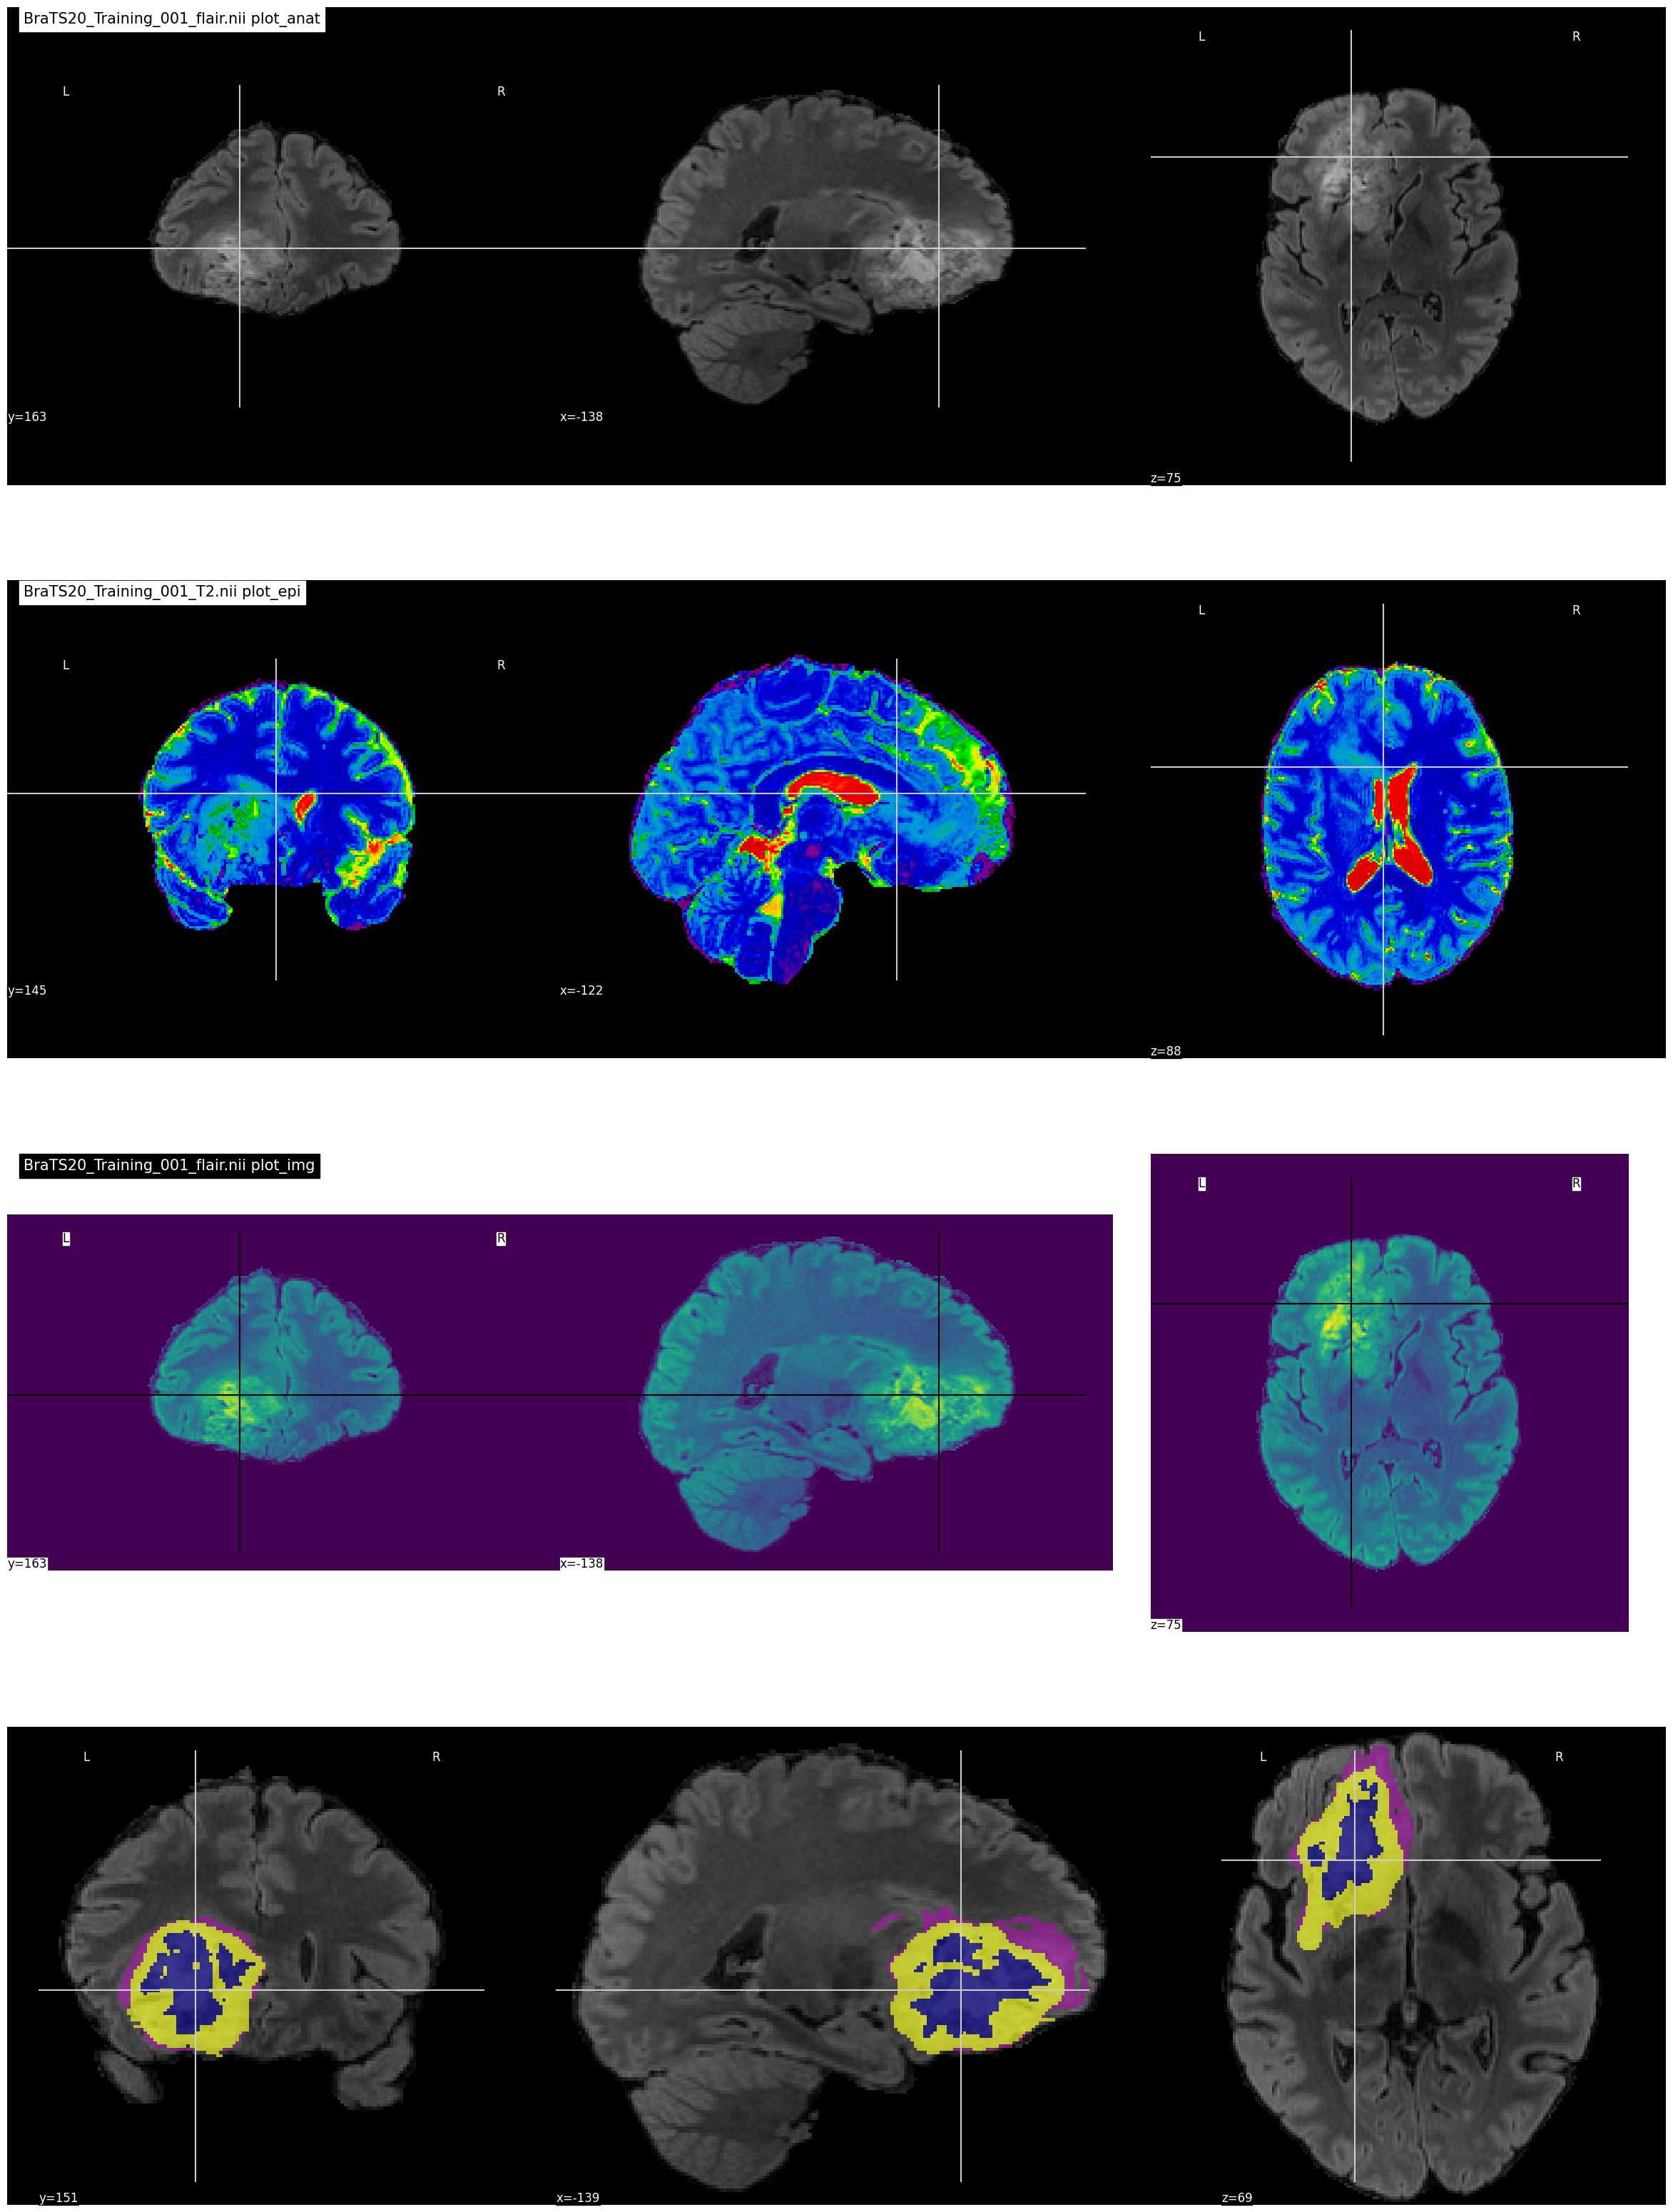

In [7]:
fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(nit2,
               title='BraTS20_Training_001_T2.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='', #BraTS20_Training_001_flair.nii with mask plot_roi
               bg_img = niimg, 
               axes = axes[3], cmap = 'plasma') # Paired

plt.show()

In [8]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA / INVADED TISSUE',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# Slices per volume: 155
# Image Size: 240 x 240

VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

# <span style="color:crimson;"> <center/> EVALUATION METRICS  </center> </span>

In [9]:
# DICE LOSS FOR THE 4 CLASSES

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# DICE COEFFICIENT PER CLASS
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [10]:
IMG_SIZE = 128 
# IMG_SIZE = 192

In [11]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)


In [12]:
def build_optim_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(192, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool3)
    conv4 = Conv2D(192, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    pool5  = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = Conv2D(384, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool5)
    conv6 = Conv2D(384, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv6)
    pool6  = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool6)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    pool7  = MaxPooling2D(pool_size=(2, 2))(conv7)
    
    drop7 = Dropout(dropout)(conv7)
    
    up6 = Conv2D(384, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop7))
    merge61 = concatenate([conv6,up6], axis = 3)
    conv61 = Conv2D(384, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge61)
    conv61 = Conv2D(384, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv61)

    up5 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv61))
    merge51 = concatenate([conv5,up5], axis = 3)
    conv51 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge51)
    conv51 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv51)

    up4 = Conv2D(192, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv51))
    merge41 = concatenate([conv4,up4], axis = 3)
    conv41 = Conv2D(192, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge41)
    conv41 = Conv2D(192, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv41)
    
    up3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv41))
    merge31 = concatenate([conv3,up3], axis = 3)
    conv31 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge31)
    conv31 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv31)
    
    up2 = Conv2D(96, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv31))
    merge21 = concatenate([conv2,up2], axis = 3)
    conv21 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge21)
    conv21 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv21)
    
    up1 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv21))
    merge11 = concatenate([conv1,up1], axis = 3)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge11)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv11)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv11)
    
    return Model(inputs = inputs, outputs = conv10)


In [13]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 3))
base_model = build_unet(input_layer, 'he_normal', 0.2)
optim_model = build_optim_unet(input_layer, 'he_normal', 0.2)

In [14]:
model = optim_model
model.compile(loss="categorical_crossentropy",
              optimizer = keras.optimizers.Adam(learning_rate=0.0005),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                         dice_coef, precision, sensitivity, specificity,
                         dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

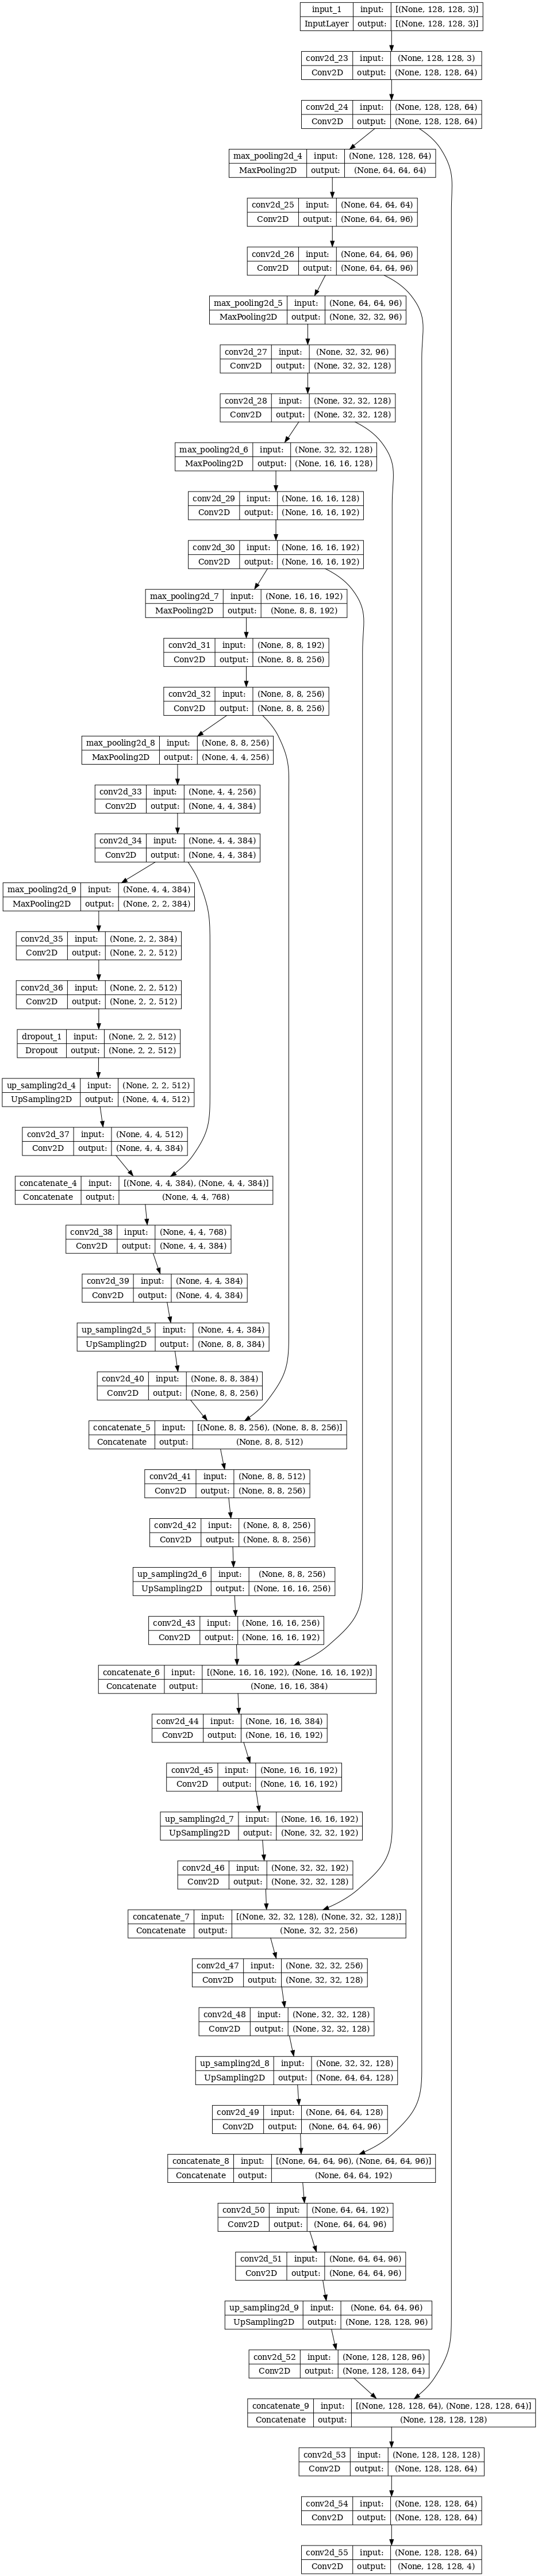

In [15]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# <span style="color:crimson;"> <center/> BraTS DATA SPLITTNG  </center> </span>

In [16]:
train_and_val_directories = [f.path for f in os.scandir(brats2021_path) if f.is_dir()]

In [17]:
train_and_val_directories[0]

'/kaggle/input/brats2022/BraTS2021/BraTS2021_00656'

In [18]:
train_test_ids, val_ids = train_test_split(train_and_val_directories,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

# <span style="color:crimson;"> <center/> FeTS DATA SPLITTNG  </center> </span>

In [19]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

In [23]:
val_dirs = [f.path for f in os.scandir(fets_val_path) if f.is_dir()]
val_ids = pathListIntoIds(val_dirs)

train_test_dirs =  [f.path for f in os.scandir(fets_train_path) if f.is_dir()]
train_test_dirs.remove(fets_train_path +'/FeTS21_Training_355')

train_test_ids = pathListIntoIds(train_test_dirs)

# Get the 13% split
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.13) 

# <span style="color:crimson;"> <center/> DATALOADER  </center> </span>

In [24]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, base_path,  dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 3, shuffle=True): # batch_size = 1,  n_channels = 2
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.base_path = base_path
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(self.base_path, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_t2.nii');
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,2] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));


                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        

In [25]:
training_generator = DataGenerator(train_ids, fets_train_path)
valid_generator = DataGenerator(val_ids, fets_val_path)
test_generator = DataGenerator(test_ids, fets_train_path)

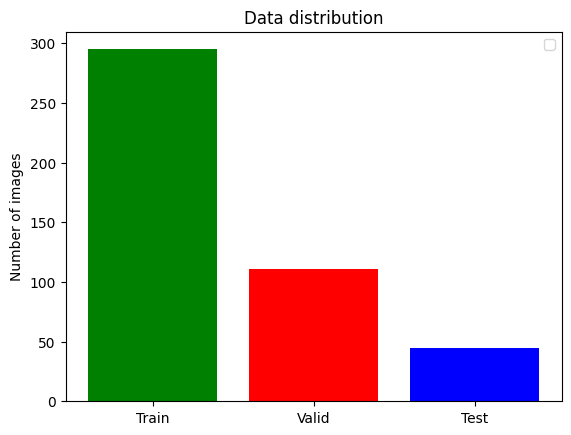

In [26]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

# <span style="color:crimson;"> <center/> HYPERPARAMETERS  </center> </span>

In [27]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                            verbose=1, save_best_only=True, save_weights_only = True),
        csv_logger
    ]

# <span style="color:crimson;"> <center/> MODEL TRANING  </center> </span>

In [ ]:
# K.clear_session()

history =  model.fit(training_generator,
                    epochs = 100 ,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
model.save("model_x1_1.h5")

Epoch 1/100
160/295 [===============>..............] - ETA: 1:50 - loss: 188.4100 - accuracy: 0.9370 - mean_io_u: 0.8160 - dice_coef: 0.2454 - precision: 0.9383 - sensitivity: 0.9316 - specificity: 0.9796 - dice_coef_necrotic: 0.0036 - dice_coef_edema: 0.0048 - dice_coef_enhancing: 9.0266e-04

# <span style="color:crimson;"> <center/> VISUALIZE TRAINING LOG  </center> </span>

# <span style="color:crimson;"> <center/> MODEL TESTING  </center> </span>